In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt 
import arviz as az 

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import scrinet.sample.sample_helpers as nn_help

from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate
from scrinet.fits import nn, scale
from scrinet.interfaces import lalutils


In [3]:
tfd = tfp.distributions

In [7]:
phase_model, phase_basis = nn_help.load_phase_model()
amp_model, amp_basis = nn_help.load_amp_model()

In [8]:
mtotal=60
qmin=1
qmax=4

In [173]:
@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def joint_log_prob(y, 
                   q, 
                   amp_model, 
                   amp_basis, 
                   phase_model,  
                   phase_basis):
    
    y_mu = nn_help.generate_surrogate(q,
                                     amp_model= amp_model,
                                      amp_basis =amp_basis, 
                                      phase_model = phase_model,
                                      phase_basis = phase_basis)[0]
    
    return -tf.math.log(tf.reduce_sum(tf.abs(y_mu-y)**2, axis=1))

@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def target_log_prob_fn(x):
    q = x
    prob = joint_log_prob(y,
                          q,
                          amp_model= amp_model,
                          amp_basis =amp_basis, 
                          phase_model = phase_model,
                          phase_basis = phase_basis )
    
    prior = tfp.distributions.Uniform(0, 5).log_prob(q)
    prior = tf.reshape(prior, (len(x),))

    return prob + prior


In [177]:
true_q = tf.constant([3.])

In [178]:
sur_hp, sur_hc, samp, sphase = nn_help.generate_surrogate(true_q,
                                                          amp_model= amp_model,
                                                          amp_basis =amp_basis, 
                                                          phase_model = phase_model,
                                                          phase_basis = phase_basis)

In [328]:
y = tf.constant(sur_hp)[0] 
y = y + + np.random.normal(0, 0.05, len(y))

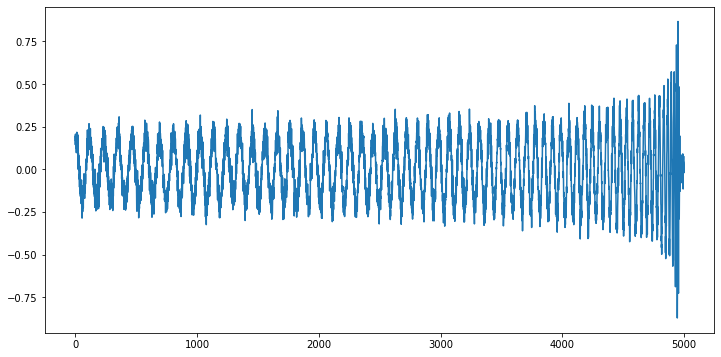

In [329]:
plt.figure(figsize = (12,6))
plt.plot(y)

In [330]:
num_chains=10
ndim = 1
## step size is tiny because the posterior is amazingly narrow!
step_size = [0.001 for i in range(num_chains)]

In [349]:
@tf.function(experimental_compile = True, experimental_relax_shapes=True )
def do_sampling(target_log_prob,
                p0 = tf.random.uniform(minval = 1.,
                                       maxval = 4,
                                       shape = (num_chains, ndim)), 
                step_size = 10**-6,
                num_results =  25 * 10**3,
                num_burnin_steps = 15 * 10**3,
                ndim =1):

    p0 = tf.cast(p0, tf.float32)

#     inner_kernel=tfp.mcmc.NoUTurnSampler(
#       target_log_prob_fn=target_log_prob_fn,
#       step_size= tf.fill([num_chains, 1], step_size))
    
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                  target_log_prob_fn=target_log_prob_fn,
#                   step_size=step_size,
                  step_size = tf.fill([num_chains, 1], step_size),
                  num_leapfrog_steps=10)
    
    inner_kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=inner_kernel,
                                                     num_adaptation_steps=int(num_burnin_steps * 0.8))
    
    posterior = tfp.mcmc.sample_chain(num_results=num_results,
                               num_burnin_steps=num_burnin_steps,
                               current_state=p0,
                               kernel=inner_kernel, 
                               trace_fn=lambda _, pkr: [pkr.inner_results.accepted_results.step_size,
                             pkr.inner_results.log_accept_ratio])
    return posterior

In [350]:
%%time
chains, [step_size_trace, log_accept_ratio]  = do_sampling(target_log_prob = target_log_prob_fn)
# chains, = do_sampling(target_log_prob = target_log_prob_fn)

p_accept = tf.reduce_mean(tf.exp(tf.minimum(log_accept_ratio, 0.)))
print(f'Acceptance rate: {p_accept}')

2020-04-02 17:13:46,928 - WARNING - 11 out of the last 11 calls to <function joint_log_prob at 0x1b41b56440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:47,006 - WARNING - 11 out of the last 11 calls to <function target_log_prob_fn at 0x1b4ac258c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:47,367 - WARNING - 11 out of the last 11 calls to <function joint_log_prob at 0x1b41b56440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:47,408 - WARNING - 11 out of the last 11 calls to <function target_log_prob_fn at 0x1b4ac258c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,263 - WARNING - 5 out of the last 5 calls to <function x_scale_hack at 0x1b6a4eb320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,350 - WARNING - 5 out of the last 5 calls to <function get_model_y_mean_scalers at 0x1b6a1b8710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,362 - WARNING - 5 out of the last 5 calls to <function get_model_y_std_scalers at 0x1b69654440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,371 - WARNING - 5 out of the last 5 calls to <function y_inv_scale_hack at 0x1b6a1b85f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,414 - WARNING - 5 out of the last 5 calls to <function predict_hack at 0x1b616c97a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,454 - WARNING - 6 out of the last 6 calls to <function x_scale_hack at 0x1b6a4eb320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,537 - WARNING - 6 out of the last 6 calls to <function get_model_y_mean_scalers at 0x1b6a1b8710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,552 - WARNING - 6 out of the last 6 calls to <function get_model_y_std_scalers at 0x1b69654440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,573 - WARNING - 6 out of the last 6 calls to <function y_inv_scale_hack at 0x1b6a1b85f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,613 - WARNING - 6 out of the last 6 calls to <function predict_hack at 0x1b616c97a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,702 - WARNING - 11 out of the last 11 calls to <function joint_log_prob at 0x1b41b56440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,756 - WARNING - 11 out of the last 11 calls to <function target_log_prob_fn at 0x1b4ac258c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,805 - WARNING - 7 out of the last 7 calls to <function x_scale_hack at 0x1b6a4eb320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,936 - WARNING - 7 out of the last 7 calls to <function get_model_y_mean_scalers at 0x1b6a1b8710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,967 - WARNING - 7 out of the last 7 calls to <function get_model_y_std_scalers at 0x1b69654440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:48,995 - WARNING - 7 out of the last 7 calls to <function y_inv_scale_hack at 0x1b6a1b85f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:49,046 - WARNING - 7 out of the last 7 calls to <function predict_hack at 0x1b616c97a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:49,109 - WARNING - 8 out of the last 8 calls to <function x_scale_hack at 0x1b6a4eb320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:49,283 - WARNING - 8 out of the last 8 calls to <function get_model_y_mean_scalers at 0x1b6a1b8710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:49,303 - WARNING - 8 out of the last 8 calls to <function get_model_y_std_scalers at 0x1b69654440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:49,327 - WARNING - 8 out of the last 8 calls to <function y_inv_scale_hack at 0x1b6a1b85f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:49,369 - WARNING - 8 out of the last 8 calls to <function predict_hack at 0x1b616c97a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:49,544 - WARNING - 11 out of the last 11 calls to <function joint_log_prob at 0x1b41b56440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


2020-04-02 17:13:49,689 - WARNING - 11 out of the last 11 calls to <function target_log_prob_fn at 0x1b4ac258c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Acceptance rate: 0.5067470073699951
CPU times: user 5min 46s, sys: 28.4 s, total: 6min 15s
Wall time: 6min 23s


In [351]:
samples = np.array(chains)

In [352]:
data = nn_helphelp.convert_tfp_chains_to_arviz_object(chains)

In [353]:
new_samples = np.swapaxes(samples, 0 , 1)

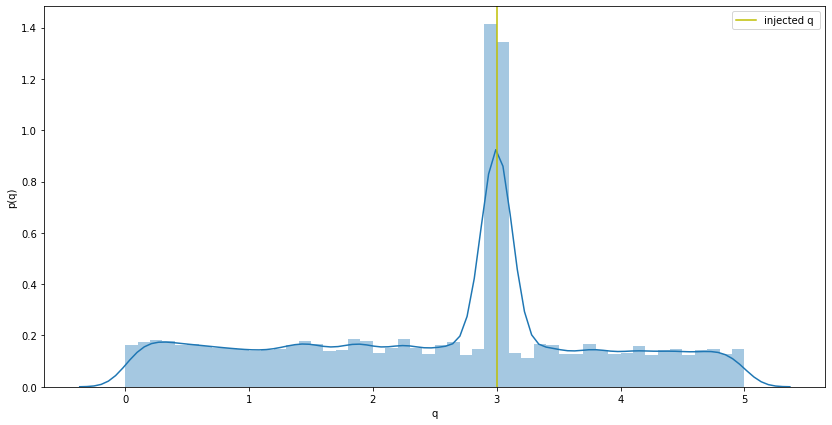

In [354]:
plt.figure(figsize = (14,7))
sns.distplot(new_samples)
plt.axvline(true_q, color = 'y',label = 'injected q ')
plt.xlabel('q')
plt.ylabel('p(q)')           
plt.legend()

In [355]:
# data = az.convert_to_inference_data(new_samples)

In [356]:
az.summary(data)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
x[0]  2.556  1.28     0.0    4.566      0.024    0.017    2901.0  2901.0   

      ess_bulk  ess_tail  r_hat  
x[0]    3035.0   10627.0   1.01

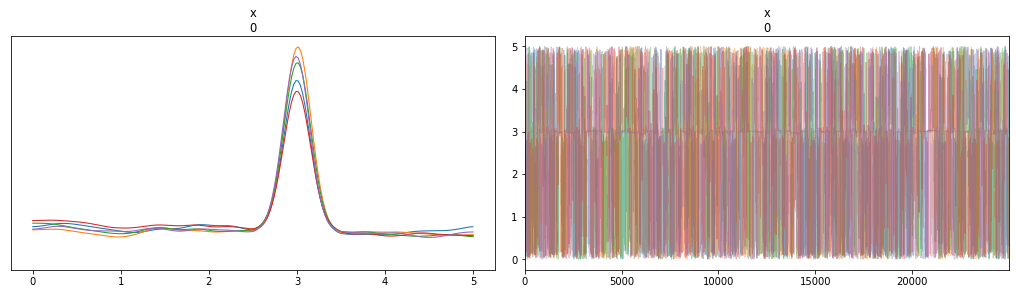

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b70bff6d0>,
      dtype=object)

In [358]:
az.plot_trace(data,
              figsize = (14,4),
              show = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1b70bf8390>],
      dtype=object)

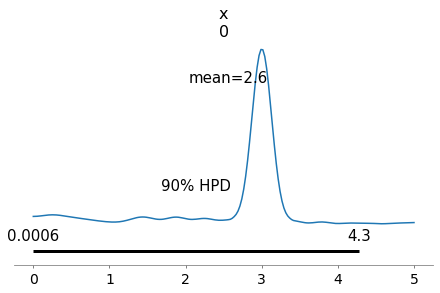

In [359]:
az.plot_posterior(data,
                  credible_interval=0.9,
                 )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1b6fd6df90>],
      dtype=object)

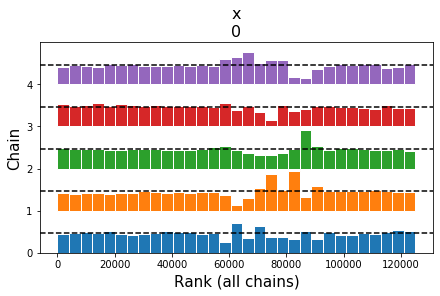

In [360]:
az.plot_rank(data)

In [361]:
az.ess(data)

<xarray.Dataset>
Dimensions:  (x_dim_0: 1)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0
Data variables:
    x        (x_dim_0) float64 3.035e+03

In [362]:
az.rhat(data)

<xarray.Dataset>
Dimensions:  (x_dim_0: 1)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0
Data variables:
    x        (x_dim_0) float64 1.006

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b7210e190>,
      dtype=object)

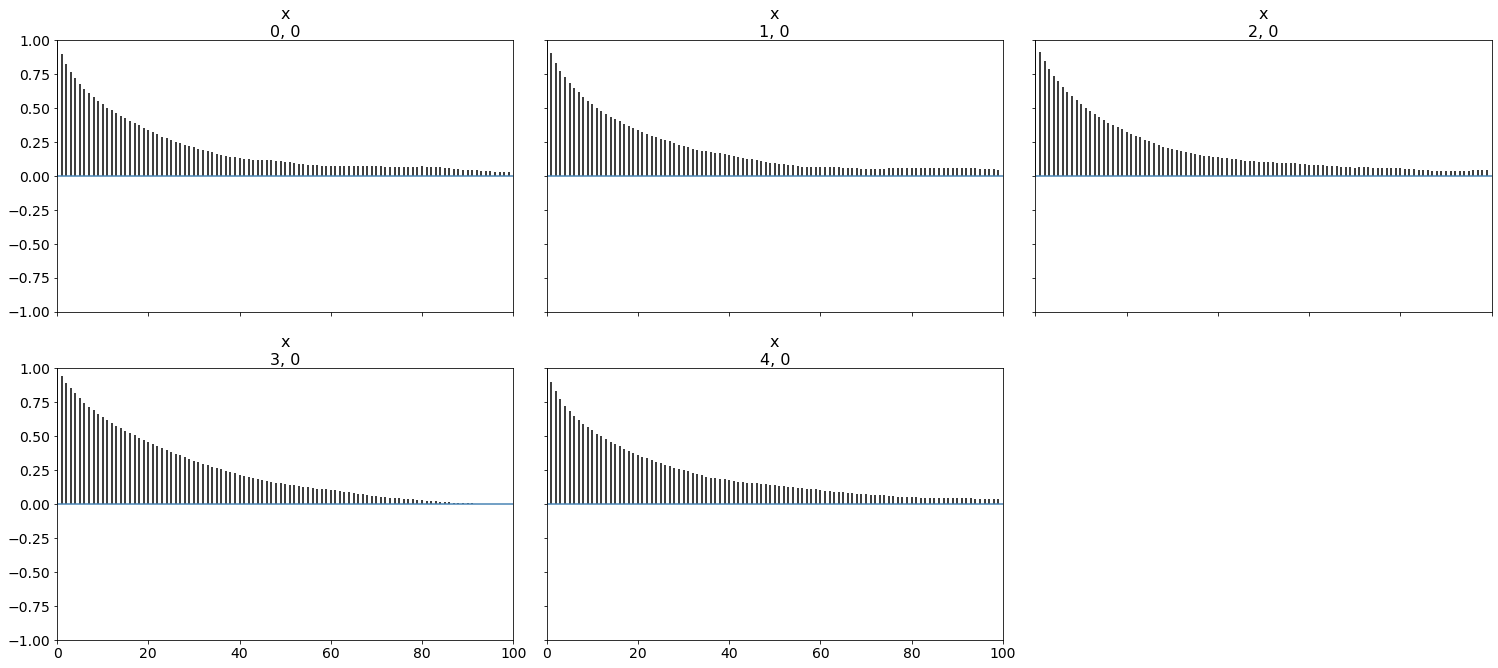

In [363]:
az.plot_autocorr(data)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1b71d5b210>],
      dtype=object)

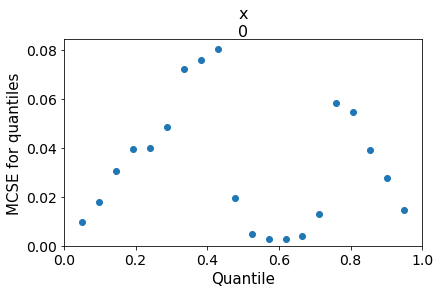

In [364]:
az.plot_mcse(new_samples)